In [0]:
# load in raw flights and weather data

from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType, IntegerType
from pyspark.sql import SQLContext
from pyspark.sql import Row

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, FeatureHasher, StandardScaler, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
# from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import neighbors
# from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
# from pyspark.mllib.tree import RandomForest, RandomForestModel, DecisionTree, DecisionTreeModel

import random
import numpy as np
import datetime
from pyspark.sql.types import TimestampType
import us
import pytz
import pandas as pd
import time
import matplotlib.pyplot as plt

sqlContext = SQLContext(sc)


**IMPORTANT --- set your path so you don't overwrite my datasets and models!!** You can read from my path but please don't do a `rm()` or `write()`.

In [0]:
path = "/Users/kkw24@ischool.berkeley.edu/final/"

## Read in joined data

In [0]:
aw = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/aw.parquet").cache()

In [0]:
N = aw.count()
print(N)

27885387

In [0]:
aw.printSchema()

root
-- DEP_DEL15: float (nullable = true)
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- ORIGIN: string (nullable = true)
-- DEST: string (nullable = true)
-- CRS_DEP_DATETIME_UTC: timestamp (nullable = true)
-- ORIGIN_p: string (nullable = true)
-- DEP_DELAY_NEW_p: float (nullable = true)
-- CARRIER_DELAY_p: float (nullable = true)
-- WEATHER_DELAY_p: float (nullable = true)
-- NAS_DELAY_p: float (nullable = true)
-- SECURITY_DELAY_p: float (nullable = true)
-- LATE_AIRCRAFT_DELAY_p: float (nullable = true)
-- FL_DATE: string (nullable = true)
-- totNumFlights: long (nullable = true)
-- meanDelayAcrossFlights: double (nullable = true)
-- propDelayed: double (nullable = true)
-- DATE_day: date (nullable = true)
-- HOUR: integer (nullable = true)
-- avgTMP_airTemp: double (nullable = true)
-- avgWND_speed: double (nullable = true)
-- avgCIG_height: double (nullable = true)
-- avgVIS_distance: double (nullable = true)
-- avgSLP_airPressure: double (nullable = true)
-- avgPRECIP_duration: double (nullable = true)
-- avgPRECIP_amount: double (nullable = true)
-- avgSNOW_depth: double (nullable = true)

# Feature transformation

In [0]:
# Convert fl_date to int
datetonum = f.udf(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").timetuple().tm_yday)
aw = aw.withColumn("DAY_OF_YEAR", datetonum(f.col("FL_DATE")).cast(IntegerType())) \
.drop("FL_DATE")

In [0]:
features = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DEP_DELAY_NEW_p', 'CARRIER_DELAY_p', 'WEATHER_DELAY_p', 'NAS_DELAY_p', 'SECURITY_DELAY_p', 'LATE_AIRCRAFT_DELAY_p', 'totNumFlights', 'meanDelayAcrossFlights', 'propDelayed', 'HOUR', 'avgTMP_airTemp', 'avgWND_speed', 'avgCIG_height', 'avgVIS_distance', 'avgSLP_airPressure', 'avgPRECIP_duration', 'avgPRECIP_amount', 'avgSNOW_depth', 'DAY_OF_YEAR', 'OP_CARRIER_index', 'ORIGIN_index', 'DEST_index', 'ORIGIN_p_index', 'DAY_OF_WEEK_index']

# Transform categorical vars --- StringIndexer
cat_cols = ["OP_CARRIER", "ORIGIN", "DEST", "ORIGIN_p", "DAY_OF_WEEK"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in cat_cols]

pipeline = Pipeline(stages=indexers)

# Fit pipeline model
df2 = pipeline.fit(aw).transform(aw).drop(*cat_cols).cache()

In [0]:
idx_models = [idx.fit(aw) for idx in indexers]

op_labels = ["op_" + i for i in idx_models[0].labels]
origin_labels = ["origin_" + i for i in idx_models[1].labels]
dest_labels = ["dest_" + i for i in idx_models[2].labels]
origin_p_labels = ["origin_p_" + i for i in idx_models[3].labels]
dow_labels = ["dow_" + i for i in idx_models[4].labels]

In [0]:
labelReverse = IndexToString().setInputCol("ORIGIN_index").setOutputCol("ORIGIN")
labelReverse.transform(df2).filter(f.col("ORIGIN")=="ATL").select("ORIGIN_index", "ORIGIN").show()

+------------+------+
ORIGIN_index|ORIGIN|
+------------+------+
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
 0.0| ATL|
+------------+------+
only showing top 20 rows

In [0]:
display(df2.describe())

summary,DEP_DEL15,YEAR,MONTH,DAY_OF_MONTH,CRS_DEP_TIME,DEP_DELAY_NEW_p,CARRIER_DELAY_p,WEATHER_DELAY_p,NAS_DELAY_p,SECURITY_DELAY_p,LATE_AIRCRAFT_DELAY_p,totNumFlights,meanDelayAcrossFlights,propDelayed,HOUR,avgTMP_airTemp,avgWND_speed,avgCIG_height,avgVIS_distance,avgSLP_airPressure,avgPRECIP_duration,avgPRECIP_amount,avgSNOW_depth,DAY_OF_YEAR,OP_CARRIER_index,ORIGIN_index,DEST_index,ORIGIN_p_index,DAY_OF_WEEK_index
count,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387,27885387
mean,0.17308054573529857,2017.1464246488672,6.565113584401751,15.762412477904645,1264.1485657344472,7.330670289782961,2.209196594617819,0.32358693820530443,1.837294673371397,0.010050819807521408,2.4358236448359136,346.064009475644,9.910952259390259,0.18135856403696407,13.452998088210144,168.9453500266698,38.54092817069208,12151.226438141763,14981.69402083801,10166.102480987123,0.4633844003432096,26.742064514531098,0.03822587555744998,184.35745173628038,3.8531775800708807,33.71893411412938,32.63700751221419,28.06686243945619,2.9014517890678726
stddev,0.37831689832181536,1.4302055032336867,3.378061805832989,8.773986288807235,471.3612611103225,29.48015846369332,18.014155286246872,7.214056322100087,11.779373826862722,0.8827813812228733,16.528553384102835,288.97094048071085,13.741411282892528,0.11593754771570046,5.5190553349461755,104.3387409405015,24.273285184247968,9619.127906056585,3116.9981772741153,66.62720884411893,2.47775659248955,17.507117932431115,0.8623752477472401,103.24938436502299,4.120081798698065,46.08308749057377,46.173915004603394,45.72950167909619,1.9726008196217417
min,0.0,2015,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1,-69.5,0.0,0,-439.0,0.0,0.0,0.0,9601.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
max,1.0,2019,12,31,2359,2710.0,1843.0,2692.0,1848.0,927.0,2454.0,1228,1970.0,1.0,21,494.0,412.0,22000.0,160000.0,10596.0,24.0,2421.0,107.0,366,18.0,353.0,366.0,367.0,6.0


In [0]:
# Vector assembly
assembler = VectorAssembler(inputCols=features, outputCol="features")

df3 = assembler.transform(df2).cache()

In [0]:
# train test split - preserve order
train = df3.filter(f.col("YEAR")!=2019)
test = df3.filter(f.col("YEAR")==2019)

# aw.unpersist()
# df2.unpersist()

In [0]:
# Get weights for class balancing on a reasonable sample

mini_train = train.sample(False, .001).cache()

mini_N = mini_train.count()
mini_num = mini_train.filter(f.col("DEP_DEL15")==0).count()

BalancingRatio= mini_num/mini_N
print('BalancingRatio = {}'.format(BalancingRatio))

# BalancingRatio = 0.8260828845703583

BalancingRatio = 0.8260828845703583

In [0]:
train_fin = train.withColumn("classWeights", f.when(train.DEP_DEL15 == 1,BalancingRatio).otherwise(1-BalancingRatio)).cache()
test_fin = test.withColumn("classWeights", f.when(test.DEP_DEL15 == 1,BalancingRatio).otherwise(1-BalancingRatio)).cache()

### START HERE if you just want to model

In [0]:
# Put in DBFS

# dbutils.fs.rm(path+"train_fin.parquet", True)
# dbutils.fs.rm(path+"test_fin.parquet", True)

# train_fin.write.parquet(path+"train_fin.parquet")
# test_fin.write.parquet(path+"test_fin.parquet")

# Note that this reads from my path
train_fin = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/train_fin.parquet").cache()
test_fin = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/test_fin.parquet").cache()

# display(dbutils.fs.ls("/Users/kkw24@ischool.berkeley.edu/final"))

In [0]:
train.unpersist()
test.unpersist()

Out[31]: DataFrame[DEP_DEL15: float, YEAR: int, MONTH: int, DAY_OF_MONTH: int, CRS_DEP_TIME: int, CRS_DEP_DATETIME_UTC: timestamp, DEP_DELAY_NEW_p: float, CARRIER_DELAY_p: float, WEATHER_DELAY_p: float, NAS_DELAY_p: float, SECURITY_DELAY_p: float, LATE_AIRCRAFT_DELAY_p: float, totNumFlights: bigint, meanDelayAcrossFlights: double, propDelayed: double, DATE_day: date, HOUR: int, avgTMP_airTemp: double, avgWND_speed: double, avgCIG_height: double, avgVIS_distance: double, avgSLP_airPressure: double, avgPRECIP_duration: double, avgPRECIP_amount: double, avgSNOW_depth: double, DAY_OF_YEAR: int, OP_CARRIER_index: double, ORIGIN_index: double, DEST_index: double, ORIGIN_p_index: double, DAY_OF_WEEK_index: double, features: vector]

# RF model

RF parameters

**DEFAULT params**
featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0, leafCol='', minWeightFractionPerNode=0.0, weightCol=None, bootstrap=True

* featureSubsetStrategy='auto' -- number of features to consider for splits at each tree node
* numTrees = number of trees in the foreset
* maxMemoryInMB = Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.')
* minInfoGain = P'Minimum information gain for a split to be considered at a tree node.')
* minInstancesPerNode = 'Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.')
* minWeightFractionPerNode = 'Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5).')
* subsamplingRate = Param(parent='undefined', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].')
* max_depth = max number of levels in each decision tree
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

All: class weights, maxBins=369

In [0]:
print(train_fin.count())
#21419666

print(test_fin.count())
# 6465721

21419666
6465721

In [0]:
# Create smaller train set
train_mini = train_fin.sample(False, 0.01).cache()

train_mini.count()

Out[10]: 214188

In [0]:
# dbutils.fs.rm(path+"train_mini.parquet", True)
# train_mini.write.parquet(path+"train_mini.parquet")
train_mini = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/train_mini.parquet").cache()

In [0]:
feature_names = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DEP_DELAY_NEW_p', 'CARRIER_DELAY_p', 'WEATHER_DELAY_p', 'NAS_DELAY_p', 'SECURITY_DELAY_p', 'LATE_AIRCRAFT_DELAY_p', 'totNumFlights', 'meanDelayAcrossFlights', 'propDelayed', 'HOUR', 'avgTMP_airTemp', 'avgWND_speed', 'avgCIG_height', 'avgVIS_distance', 'avgSLP_airPressure', 'avgPRECIP_duration', 'avgPRECIP_amount', 'avgSNOW_depth', 'DAY_OF_YEAR', 'OP_CARRIER_index', 'ORIGIN_index', 'DEST_index', 'ORIGIN_p_index', 'DAY_OF_WEEK_index']

In [0]:
train_mini.count()

Out[5]: 21497

## Train-eval pipeline

In [0]:
# Train-eval pipeline

def train_eval(traindata=train_mini, testdata = test_fin, features="features", trees=20, depth=5, weights=True):

  # Train
  start_time = time.time()
  if weights:
    m = RandomForestClassifier(labelCol="DEP_DEL15", featuresCol=features, maxBins = 369, numTrees=trees, maxDepth = depth, maxMemoryInMB=1000, weightCol="classWeights")
  else:
    m = RandomForestClassifier(labelCol="DEP_DEL15", featuresCol=features, maxBins = 369, numTrees=trees, maxDepth = depth, maxMemoryInMB=1000)
  m_model=m.fit(traindata)
  traintime = time.time() - start_time

  # Eval
  start_time = time.time()
  train_pred = m_model.transform(traindata)
  test_pred = m_model.transform(testdata)
  predicttime = time.time() - start_time
  
  test_preds = [prediction[0] for prediction in test_pred.select('prediction').collect()]
  test_labels = [label[0] for label in test_pred.select('DEP_DEL15').collect()]
  
  train_preds = [prediction[0] for prediction in train_pred.select('prediction').collect()]
  train_labels = [label[0] for label in train_pred.select('DEP_DEL15').collect()]
  
  cm = confusion_matrix(test_labels, test_preds)
  
  acc = (cm[0,0] + cm[1,1])/np.sum(cm)
  prec = cm[1,1]/(cm[1,1] + cm[0,1])
  recall = cm[1,1]/(cm[1,1] + cm[1,0])
  f1 = 2*(prec*recall)/(prec+recall)
  
  cm2 = confusion_matrix(train_labels, train_preds)
  prec2 = cm2[1,1]/(cm2[1,1] + cm2[0,1])
  recall2 = cm2[1,1]/(cm2[1,1] + cm2[1,0])
  trainf1 = 2*(prec2*recall2)/(prec2+recall2)
  
  # examine feature importance
  importance = DenseVector(m_model.featureImportances)
  rf_importance = pd.DataFrame(list(zip(feature_names, importance)), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
  
  params = [features, trees, depth, traintime, predicttime]
  metrics = [cm, acc, prec, recall, f1, cm2, trainf1]
  
  print("params", params)
  print("metrics", metrics)
  
  return params, metrics, test_pred, rf_importance

In [0]:
# Search tree depth
depths = [3, 5, 10]

metrics_list = []
param_list = []

for d in depths:
  params, metrics, rf_importance = train_eval(trees=20, depth=d)
  metrics_list.append(metrics)
  param_list.append(params)

params ['features', 20, 3, 11.732930421829224, 0.16115522384643555]
metrics [array([[4965130, 349113],
 [ 567343, 584135]]), 0.8582592722451217, 0.6259161551913318, 0.507291498404659, 0.560394987158984, array([[16694, 1057],
 [ 1813, 1933]]), 0.560394987158984]
params ['features', 20, 5, 10.500224590301514, 0.14582490921020508]
metrics [array([[4972283, 341960],
 [ 570098, 581380]]), 0.8589394748087645, 0.6296488834015639, 0.5048989212125633, 0.5604154195693308, array([[16835, 916],
 [ 1812, 1934]]), 0.5604154195693308]
params ['features', 20, 10, 2.5810043811798096, 0.053002357482910156]
metrics [array([[4920463, 393780],
 [ 561116, 590362]]), 0.8523140729394293, 0.5998748148133095, 0.5126993307731454, 0.552871765576273, array([[17040, 711],
 [ 1491, 2255]]), 0.552871765576273]

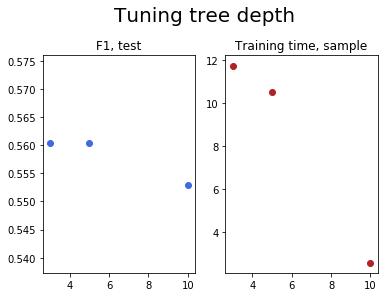

In [0]:
f1_depth = [x[4] for x in metrics_list]
traintimes = [x[3] for x in param_list]

plt.subplot(1, 2, 1)
plt.scatter(depths, f1_depth, color = "royalblue")
plt.title("F1, test")

plt.subplot(1, 2, 2)
plt.scatter(depths, traintimes, color = "firebrick")
plt.title("Training time, sample")

plt.suptitle("Tuning tree depth", size=20, y=1.05)

plt.show()

In [0]:
# Search num trees
nT = [20, 30, 40]

metrics_list_trees = []
param_list_trees = []

for t in nT:
  params, metrics, rf_importance = train_eval(trees=t, depth=5)
  metrics_list_trees.append(metrics)
  param_list_trees.append(params)

params ['features', 20, 5, 20.960612297058105, 0.15358877182006836]
metrics [array([[4935750, 378493],
 [ 559535, 591943]]), 0.8549229080561935, 0.6099763405314724, 0.514072348755252, 0.5579330736306939, array([[165722, 11728],
 [ 17555, 19183]]), 0.5671332909577377]
params ['features', 30, 5, 85.93611526489258, 0.15213727951049805]
metrics [array([[4928210, 386033],
 [ 557835, 593643]]), 0.854019683187691, 0.605958500565493, 0.5155487121768718, 0.5571094346067905, array([[165464, 11986],
 [ 17496, 19242]]), 0.5662242886148957]
params ['features', 40, 5, 33.739585399627686, 0.7616114616394043]
metrics [array([[4915846, 398397],
 [ 555006, 596472]]), 0.8525449829957092, 0.5995482822361538, 0.5180055546002615, 0.5558020208288781, array([[165015, 12435],
 [ 17406, 19332]]), 0.5643967593606306]

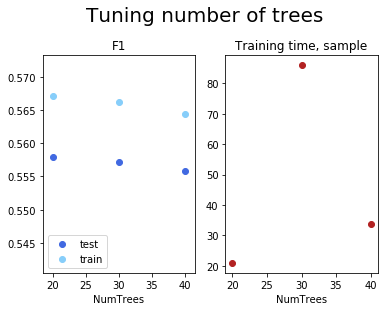

In [0]:
f1_trees = [x[4] for x in metrics_list_trees]
f1_train = [x[6] for x in metrics_list_trees]
traintimes = [x[3] for x in param_list_trees]

plt.subplot(1, 2, 1)
plt.scatter(nT, f1_trees, color = "royalblue", label="test")
plt.scatter(nT, f1_train, color = "lightskyblue", label="train")
plt.legend(loc='lower left')
plt.xlabel("NumTrees")
plt.title("F1")

plt.subplot(1, 2, 2)
plt.scatter(nT, traintimes, color = "firebrick")
plt.xlabel("NumTrees")
plt.title("Training time, sample")

plt.suptitle("Tuning number of trees", size=20, y=1.05)
plt.show()

In [0]:
# Full training run with all data, full features

params0, metrics0, rf_importance0 = train_eval(traindata=train_fin, trees=20, depth=5)

params ['features', 20, 5, 158.54557704925537, 0.14339995384216309]
metrics [array([[4916436, 397807],
 [ 555528, 595950]]), 0.8525554999976027, 0.5996938889487068, 0.5175522241849171, 0.5556034653546115, array([[16487980, 1256746],
 [ 1752397, 1922543]]), 0.560980089810247]

Out[27]:

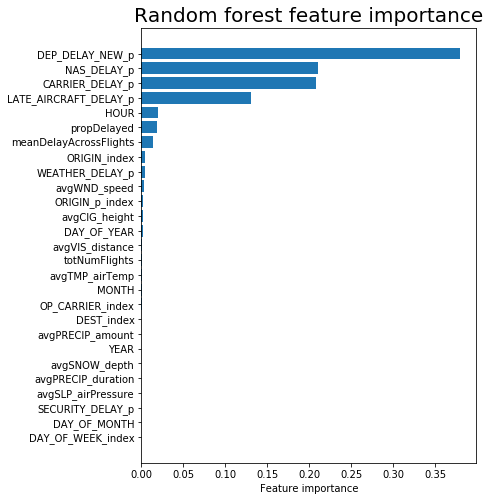

Text(0.5, 1.0, 'Random forest feature importance')

In [0]:
plt.figure(figsize=(6,8))
plt.barh(rf_importance0.feature, rf_importance0.importance)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Random forest feature importance", size=20)

In [0]:
rf_importance0

Out[28]:

,feature,importance
3,DEP_DELAY_NEW_p,3.800146e-01
6,NAS_DELAY_p,2.109426e-01
4,CARRIER_DELAY_p,2.075370e-01
8,LATE_AIRCRAFT_DELAY_p,1.308915e-01
12,HOUR,1.956967e-02
11,propDelayed,1.822840e-02
10,meanDelayAcrossFlights,1.369449e-02
23,ORIGIN_index,3.828014e-03
5,WEATHER_DELAY_p,3.801498e-03
14,avgWND_speed,2.785659e-03


In [0]:
# Get list of reduced features

# feat_red = list(rf_importance0[rf_importance0.importance>.001].feature)
# print(feat_red)

feat_red = ['DEP_DELAY_NEW_p', 'NAS_DELAY_p', 'CARRIER_DELAY_p', 'LATE_AIRCRAFT_DELAY_p', 'HOUR', 'propDelayed', 'meanDelayAcrossFlights', 'ORIGIN_index', 'WEATHER_DELAY_p', 'avgWND_speed', 'ORIGIN_p_index', 'avgCIG_height', 'DAY_OF_YEAR', 'avgVIS_distance']

In [0]:
# create new feature vector with only reduced features

assembler2 = VectorAssembler(inputCols=feat_red, outputCol="feat_red")
train_fin2 = assembler2.transform(train_fin).cache()
test_fin2 = assembler2.transform(test_fin).cache()
print(train_fin2.count())
print(test_fin2.count())

21419666
6465721

In [0]:
# Train full with reduced features
params1, metrics1, rf_importance1 = train_eval(traindata=train_fin2, testdata = test_fin2, features="feat_red", trees=20, depth=5)

params ['feat_red', 20, 5, 148.12292003631592, 0.1641390323638916]
metrics [array([[4913175, 401068],
 [ 555306, 596172]]), 0.8520854828100377, 0.597821988688781, 0.5177450198787993, 0.5549094855630193, array([[16475511, 1269215],
 [ 1751680, 1923260]]), 0.5601117742265467]

In [0]:
# Train with less data
train_18 = train_fin2.filter(f.col("YEAR")==2018).cache()
train_18.count()

Out[102]: 6345905

In [0]:
# dbutils.fs.rm(path+"train_18.parquet", True)

# train_18.write.parquet(path+"train_18.parquet")

# Note that this reads from my path
train_18 = spark.read.parquet("/Users/kkw24@ischool.berkeley.edu/final/train_18.parquet").cache()

In [0]:
params3, metrics3, rf_importance3 = train_eval(traindata=train_18, testdata = test_fin2, trees=20, depth=5)

# params = [features, trees, depth, traintime, predicttime]
# metrics = [cm, acc, prec, recall, f1, cm2, trainf1]

params ['features', 20, 5, 126.83258414268494, 0.15303683280944824]
metrics [array([[4918747, 395496],
 [ 555157, 596321]]), 0.8529703029252268, 0.6012409547325767, 0.5178744187904589, 0.5564525648592472, array([[4845475, 387086],
 [ 524060, 589284]]), 0.5639853109085741]

In [0]:
import numpy as np
cm = np.array([[4918747,  395496], [ 555157,  596321]])

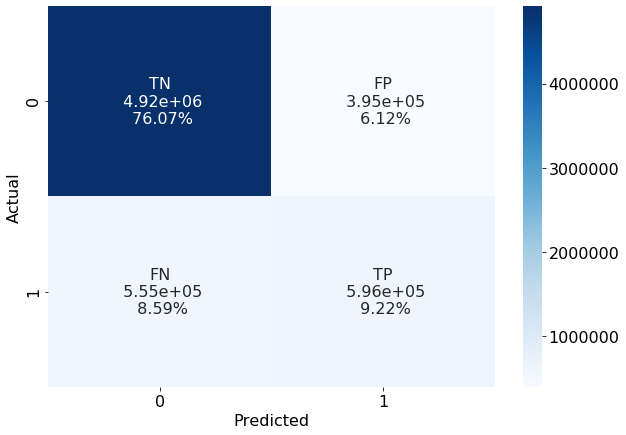

In [0]:
# Show confusion matrix
import seaborn as sns

confusionMat = cm
percents = [str(round(quadrant/sum(confusionMat.flatten())*100, 2))+'%' for quadrant in confusionMat.flatten()]
labels = (np.asarray(["{0}\n {1:.3g}\n {2}".format(string, value, percent)
                      for string, value, percent in zip(['TN', 'FP', 'FN', 'TP']
                                                        , confusionMat.flatten()
                                                        , percents
                                                       )
                     ])
         ).reshape(2, 2)

figH, axH = plt.subplots(figsize=(10, 7))
axH = sns.heatmap(confusionMat, annot=labels, annot_kws={"fontsize":16}, fmt="", cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.rcParams.update({'xtick.labelsize': 16,
                    'ytick.labelsize': 16})

In [0]:
params3b, metrics3b, test_pred3b, rf_importance3b = train_eval(traindata=train_18, testdata = test_fin2, trees=20, depth=5)

params ['features', 20, 5, 81.29691433906555, 0.14820003509521484]
metrics [array([[4918747, 395496],
 [ 555157, 596321]]), 0.8529703029252268, 0.6012409547325767, 0.5178744187904589, 0.5564525648592472, array([[4845475, 387086],
 [ 524060, 589284]]), 0.5639853109085741]

In [0]:
test_pred3b.printSchema()

root
-- DEP_DEL15: float (nullable = true)
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- CRS_DEP_TIME: integer (nullable = true)
-- CRS_DEP_DATETIME_UTC: timestamp (nullable = true)
-- DEP_DELAY_NEW_p: float (nullable = true)
-- CARRIER_DELAY_p: float (nullable = true)
-- WEATHER_DELAY_p: float (nullable = true)
-- NAS_DELAY_p: float (nullable = true)
-- SECURITY_DELAY_p: float (nullable = true)
-- LATE_AIRCRAFT_DELAY_p: float (nullable = true)
-- totNumFlights: long (nullable = true)
-- meanDelayAcrossFlights: double (nullable = true)
-- propDelayed: double (nullable = true)
-- DATE_day: date (nullable = true)
-- HOUR: integer (nullable = true)
-- avgTMP_airTemp: double (nullable = true)
-- avgWND_speed: double (nullable = true)
-- avgCIG_height: double (nullable = true)
-- avgVIS_distance: double (nullable = true)
-- avgSLP_airPressure: double (nullable = true)
-- avgPRECIP_duration: double (nullable = true)
-- avgPRECIP_amount: double (nullable = true)
-- avgSNOW_depth: double (nullable = true)
-- DAY_OF_YEAR: integer (nullable = true)
-- OP_CARRIER_index: double (nullable = true)
-- ORIGIN_index: double (nullable = true)
-- DEST_index: double (nullable = true)
-- ORIGIN_p_index: double (nullable = true)
-- DAY_OF_WEEK_index: double (nullable = true)
-- features: vector (nullable = true)
-- classWeights: double (nullable = true)
-- feat_red: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
probs = [prob[0][1] for prob in test_pred3b.select('probability').collect()]
labs = [label[0] for label in test_pred3b.select('DEP_DEL15').collect()]

dens_dt = pd.DataFrame(list(zip(probs, labs)), columns=["probability", "label"])

dens_dt.head()

Out[62]:

,probability,label
0,0.355886,0.0
1,0.355886,0.0
2,0.355886,0.0
3,0.355886,0.0
4,0.355886,0.0


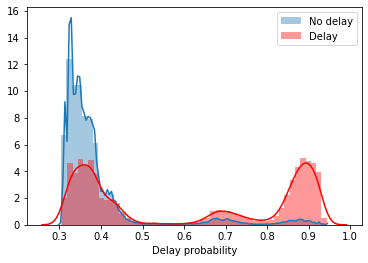

In [0]:
sns.distplot(dens_dt[dens_dt.label==0].probability)
sns.distplot(dens_dt[dens_dt.label==1].probability, color="red")
plt.xlabel("Delay probability")
plt.legend(labels=["No delay", "Delay"])
plt.show()

In [0]:
sns.__version__

Out[67]: '0.10.0'

In [0]:
params4, metrics4, rf_importance4 = train_eval(traindata=train_18, testdata = test_fin2, trees=400, depth=5)

params ['features', 400, 5, 599.7463130950928, 0.15582489967346191]
metrics [array([[4907903, 406340],
 [ 553653, 597825]]), 0.8515257617827927, 0.5953453864653717, 0.5191805661940567, 0.5546604887729555, array([[4833630, 398931],
 [ 522240, 591104]]), 0.5620518223296895]

### Undersampling

In [0]:
# BalancingRatio = 0.8260828845703583

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2834511320013826> in <module> 
 ----> 1 Balancing_ratio

 NameError : name 'Balancing_ratio' is not defined

In [0]:
# random undersampling
majordf = train_18.filter(f.col("DEP_DEL15")==0)

sampled_majority_df = majordf.sample(False, .2105322)
print(sampled_majority_df.count())

minordf = train_18.filter(f.col("DEP_DEL15")==1)
print(minordf.count())

1100801
1113344

In [0]:
train_18_under = sampled_majority_df.unionAll(minordf)
print(train_18_under.count())

2214145

In [0]:
params5, metrics5, rf_importance5 = train_eval(traindata=train_18_under, testdata = test_fin2, trees=100, depth=5, weights=False)

params ['features', 100, 5, 145.68975114822388, 0.17165064811706543]
metrics [array([[4898833, 415410],
 [ 551766, 599712]]), 0.8504148261268929, 0.5907782512840821, 0.5208193295920547, 0.5535973414566603, array([[1015165, 85636],
 [ 520351, 592993]]), 0.6618325164497456]

In [0]:
origin_labels

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2834511320014357> in <module> 
 ----> 1 origin_labels

 NameError : name 'origin_labels' is not defined

In [0]:
# single airport
atl_18 = train_18.filter(f.col("ORIGIN_index")==0)
atl_test = test_fin.filter(f.col("ORIGIN_index")==0)

print(atl_18.count())
print(atl_test.count())

340189
342104

In [0]:
params6, metrics6, test_pred6, rf_importance6 = train_eval(traindata=atl_18, testdata = atl_test, trees=100, depth=5)

params ['features', 100, 5, 48.837963819503784, 0.05513644218444824]
metrics [array([[263556, 24641],
 [ 28239, 25668]]), 0.8454271215770642, 0.5102069212268182, 0.4761533752573877, 0.4925923082827972, array([[256707, 25853],
 [ 28713, 28916]]), 0.5145287282691863]

### SMOTE

In [0]:
!pip install -U imbalanced-learn

Collecting imbalanced-learn
 Downloading imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
██ | 10 kB 38.3 MB/s eta 0:00:01 |████ | 20 kB 42.7 MB/s eta 0:00:01 |█████▉ | 30 kB 49.5 MB/s eta 0:00:01 |███████▉ | 40 kB 53.2 MB/s eta 0:00:01 |█████████▉ | 51 kB 44.2 MB/s eta 0:00:01 |███████████▊ | 61 kB 46.7 MB/s eta 0:00:01 |█████████████▊ | 71 kB 33.0 MB/s eta 0:00:01 |███████████████▊ | 81 kB 34.5 MB/s eta 0:00:01 |█████████████████▋ | 92 kB 33.4 MB/s eta 0:00:01 |███████████████████▋ | 102 kB 33.9 MB/s eta 0:00:01 |█████████████████████▋ | 112 kB 33.9 MB/s eta 0:00:01 |███████████████████████▌ | 122 kB 33.9 MB/s eta 0:00:01 |█████████████████████████▌ | 133 kB 33.9 MB/s eta 0:00:01 |███████████████████████████▌ | 143 kB 33.9 MB/s eta 0:00:01 |█████████████████████████████▍ | 153 kB 33.9 MB/s eta 0:00:01 |███████████████████████████████▍| 163 kB 33.9 MB/s eta 0:00:01 |████████████████████████████████| 167 kB 33.9 MB/s 
Requirement already satisfied, skipping upgrade: scipy>=0.19.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from imbalanced-learn) (1.4.1)
Collecting scikit-learn>=0.23
 Downloading scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
 | 10 kB 7.8 MB/s eta 0:00:01 | | 20 kB 13.9 MB/s eta 0:00:01 |▏ | 30 kB 17.3 MB/s eta 0:00:01 |▏ | 40 kB 21.6 MB/s eta 0:00:01 |▎ | 51 kB 25.3 MB/s eta 0:00:01 |▎ | 61 kB 28.7 MB/s eta 0:00:01 |▍ | 71 kB 28.8 MB/s eta 0:00:01 |▍ | 81 kB 31.3 MB/s eta 0:00:01 |▍ | 92 kB 33.4 MB/s eta 0:00:01 |▌ | 102 kB 35.6 MB/s eta 0:00:01 |▌ | 112 kB 35.6 MB/s eta 0:00:01 |▋ | 122 kB 35.6 MB/s eta 0:00:01 |▋ | 133 kB 35.6 MB/s eta 0:00:01 |▊ | 143 kB 35.6 MB/s eta 0:00:01 |▊ | 153 kB 35.6 MB/s eta 0:00:01 |▊ | 163 kB 35.6 MB/s eta 0:00:01 |▉ | 174 kB 35.6 MB/s eta 0:00:01 |▉ | 184 kB 35.6 MB/s eta 0:00:01 |█ | 194 kB 35.6 MB/s eta 0:00:01 |█ | 204 kB 35.6 MB/s eta 0:00:01 |█ | 215 kB 35.6 MB/s eta 0:00:01 |█ | 225 kB 35.6 MB/s eta 0:00:01 |█ | 235 kB 35.6 MB/s eta 0:00:01 |█▏ | 245 kB 35.6 MB/s eta 0:00:01 |█▏ | 256 kB 35.6 MB/s eta 0:00:01 |█▎ | 266 kB 35.6 MB/s eta 0:00:01 |█▎ | 276 kB 35.6 MB/s eta 0:00:01 |█▍ | 286 kB 35.6 MB/s eta 0:00:01 |█▍ | 296 kB 35.6 MB/s eta 0:00:01 |█▍ | 307 kB 35.6 MB/s eta 0:00:01 |█▌ | 317 kB 35.6 MB/s eta 0:00:01 |█▌ | 327 kB 35.6 MB/s eta 0:00:01 |█▋ | 337 kB 35.6 MB/s eta 0:00:01 |█▋ | 348 kB 35.6 MB/s eta 0:00:01 |█▊ | 358 kB 35.6 MB/s eta 0:00:01 |█▊ | 368 kB 35.6 MB/s eta 0:00:01 |█▊ | 378 kB 35.6 MB/s eta 0:00:01 |█▉ | 389 kB 35.6 MB/s eta 0:00:01 |█▉ | 399 kB 35.6 MB/s eta 0:00:01 |██ | 409 kB 35.6 MB/s eta 0:00:01 |██ | 419 kB 35.6 MB/s eta 0:00:01 |██ | 430 kB 35.6 MB/s eta 0:00:01 |██ | 440 kB 35.6 MB/s eta 0:00:01 |██▏ | 450 kB 35.6 MB/s eta 0:00:01 |██▏ | 460 kB 35.6 MB/s eta 0:00:01 |██▏ | 471 kB 35.6 MB/s eta 0:00:01 |██▎ | 481 kB 35.6 MB/s eta 0:00:01 |██▎ | 491 kB 35.6 MB/s eta 0:00:01 |██▍ | 501 kB 35.6 MB/s eta 0:00:01 |██▍ | 512 kB 35.6 MB/s eta 0:00:01 |██▌ | 522 kB 35.6 MB/s eta 0:00:01 |██▌ | 532 kB 35.6 MB/s eta 0:00:01 |██▌ | 542 kB 35.6 MB/s eta 0:00:01 |██▋ | 552 kB 35.6 MB/s eta 0:00:01 |██▋ | 563 kB 35.6 MB/s eta 0:00:01 |██▊ | 573 kB 35.6 MB/s eta 0:00:01 |██▊ | 583 kB 35.6 MB/s eta 0:00:01 |██▉ | 593 kB 35.6 MB/s eta 0:00:01 |██▉ | 604 kB 35.6 MB/s eta 0:00:01 |██▉ | 614 kB 35.6 MB/s eta 0:00:01 |███ | 624 kB 35.6 MB/s eta 0:00:01 |███ | 634 kB 35.6 MB/s eta 0:00:01 |███ | 645 kB 35.6 MB/s eta 0:00:01 |███ | 655 kB 35.6 MB/s eta 0:00:01 |███▏ | 665 kB 35.6 MB/s eta 0:00:01 |███▏ | 675 kB 35.6 MB/s eta 0:00:01 |███▏ | 686 kB 35.6 MB/s eta 0:00:01 |███▎ | 696 kB 35.6 MB/s eta 0:00:01 |███▎ | 706 kB 35.6 MB/s eta 0:00:01 |███▍ | 716 kB 35.6 MB/s eta 0:00:01 |███▍ | 727 kB 35.6 MB/s eta 0:00:01 |███▌ | 737 kB 35.6 MB/s eta 0:00:01 |███▌ | 747 kB 35.6 MB/s eta 0:00:01 |███▌ | 757 kB 35.6 MB/s eta 0:00:01 |███▋ | 768 kB 35.6 MB/s eta 0:00:01 |███▋ | 778 kB 35.6 MB/s eta 0:00:01 |███▊ | 788 kB 35.6 MB/s eta 0:00

In [0]:
print(feat_red)

# index variables are 7 and 10

['DEP_DELAY_NEW_p', 'NAS_DELAY_p', 'CARRIER_DELAY_p', 'LATE_AIRCRAFT_DELAY_p', 'HOUR', 'propDelayed', 'meanDelayAcrossFlights', 'ORIGIN_index', 'WEATHER_DELAY_p', 'avgWND_speed', 'ORIGIN_p_index', 'avgCIG_height', 'DAY_OF_YEAR', 'avgVIS_distance']
Out[10]: 'ORIGIN_p_index'

In [0]:
X = np.array(train_18.select(feat_red).collect())
Y = np.array(train_18.select("DEP_DEL15").collect())

In [0]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(random_state=24601, categorical_features=[7, 10], sampling_strategy='minority', n_jobs=3)

In [0]:
X_res, Y_res = sm.fit_resample(X, Y)

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:381)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:345)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:232)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:275)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:345)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
X_res.shape

Out[34]: (35502, 14)

In [0]:
array_res = np.hstack((X_res, Y_res.reshape(35502, 1)))

In [0]:
train_mini.select(feat_red + ["DEP_DEL15"]).printSchema()

root
-- DEP_DELAY_NEW_p: float (nullable = true)
-- NAS_DELAY_p: float (nullable = true)
-- CARRIER_DELAY_p: float (nullable = true)
-- LATE_AIRCRAFT_DELAY_p: float (nullable = true)
-- HOUR: integer (nullable = true)
-- propDelayed: double (nullable = true)
-- meanDelayAcrossFlights: double (nullable = true)
-- ORIGIN_index: double (nullable = true)
-- WEATHER_DELAY_p: float (nullable = true)
-- avgWND_speed: double (nullable = true)
-- ORIGIN_p_index: double (nullable = true)
-- avgCIG_height: double (nullable = true)
-- DAY_OF_YEAR: integer (nullable = true)
-- avgVIS_distance: double (nullable = true)
-- DEP_DEL15: float (nullable = true)

In [0]:
def recast(x):
  x[4] = int(x[4])
  x[12] = int(x[12])
  return x

In [0]:
rdd = sc.parallelize(array_res).map(lambda x: x.tolist()) \
.map(lambda x: recast(x))
df_res = spark.createDataFrame(rdd, train_schema)
df_res.show(1)

+---------------+-----------+---------------+---------------------+----+-----------+----------------------+------------+---------------+------------+--------------+-------------+-----------+---------------+---------+
DEP_DELAY_NEW_p|NAS_DELAY_p|CARRIER_DELAY_p|LATE_AIRCRAFT_DELAY_p|HOUR|propDelayed|meanDelayAcrossFlights|ORIGIN_index|WEATHER_DELAY_p|avgWND_speed|ORIGIN_p_index|avgCIG_height|DAY_OF_YEAR|avgVIS_distance|DEP_DEL15|
+---------------+-----------+---------------+---------------------+----+-----------+----------------------+------------+---------------+------------+--------------+-------------+-----------+---------------+---------+
 0.0| 0.0| 0.0| 0.0| 12| 0.16| 15.12| 94.0| 0.0| 0.0| 0.0| 22000.0| 2| 14484.0| 0.0|
+---------------+-----------+---------------+---------------------+----+-----------+----------------------+------------+---------------+------------+--------------+-------------+-----------+---------------+---------+
only showing top 1 row

In [0]:
# assemble vector
assembler2 = VectorAssembler(inputCols=feat_red, outputCol="feat_red")
train_mini_res = assembler2.transform(df_res).cache()
test_fin2 = assembler2.transform(test_fin).cache()
print(train_mini_res.count())
print(test_fin2.count())

35502
6465721

In [0]:
params6, metrics6, test_pred6, rf_importance6 = train_eval(traindata=train_mini_res, testdata = test_fin2, features="feat_red", trees=20, depth=5, weights=False)

params ['feat_red', 20, 5, 32.245293855667114, 0.13186097145080566]
metrics [array([[4612187, 702056],
 [ 501492, 649986]]), 0.8138571088978321, 0.4807439413864362, 0.5644797382147119, 0.5192576851792676, array([[15551, 2200],
 [ 5727, 12024]]), 0.7520875684128224]

In [0]:
  metrics = [cm, acc, prec, recall, f1, cm2, trainf1]

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2834511320028953> in <module> 
 ----> 1 metrics6

 NameError : name 'metrics6' is not defined